# Preprocessing Data

## Load Data

### Load packages

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import scipy.io as scio
import episcanpy.api as epi
from matplotlib import pyplot as plt

### Specify required paths

In [2]:
GTF_PATH = '/mnt/workspace_stud/mbentse/homo_sapiens/homo_sapiens.104.mainChr.gtf'
INPUT_PATH = '/mnt/workspace_stud/mbentse/catlas_objects'
OUTPUT_PATH = '/mnt/workspace_stud/stud2/output'

### Define tissue sample and necessary files

In [3]:
# Example of reading mutlipe files into one matrix. Adjust for h5ad reading.
# See more at: https://github.com/theislab/scanpy/issues/267
TISSUE = 'liver_complete'

filenames = ['liver_sample_35.h5ad',
'liver_sample_37.h5ad',
'liver_sample_40.h5ad',
'liver_sample_43.h5ad',
'liver_sample_46.h5ad',
'liver_sample_7.h5ad',
'liver_sample_9.h5ad']

### Set up output folder structur

In [4]:
# create output folder structure
command = f"mkdir -p {OUTPUT_PATH}/{TISSUE}/{{preprocessing,wp3,wp4,wp6}}"
!$command
print(command)

mkdir -p /mnt/workspace_stud/stud2/output/liver_complete/{preprocessing,wp3,wp4,wp6}


## Read and customize data

### Read and concatenate files into single Anndata object

In [5]:
adatas = [ad.read(f'{INPUT_PATH}/{filename}') for filename in filenames]
adata = adatas[0].concatenate(adatas[1:])

### Remove cells without features or empty features

In [6]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 194628 × 1151968
    obs: 'batch', 'nb_features', 'log_nb_features'
    var: 'n_cells'

### Adjust peak names

In [7]:
names = []
for name in adata.var_names:
    names.append(name)

for i, n in enumerate(names):
    tmp = names[i].replace(':', '_')
    tmp = tmp.replace('-', '_')
    tmp = tmp.split('_')
    names[i] = '_'.join([tmp[0], tmp[-2], tmp[-1]])

adata.var_names = pd.Index(names)

### Save different layers

In [8]:
adata.raw = adata

In [9]:
epi.pp.binarize(adata)
adata.layers['binary'] = adata.X.copy()

## Filter Data

### Visualize feature distribution (Histogram)

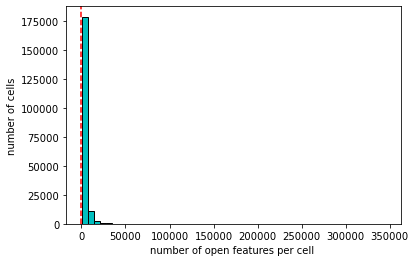

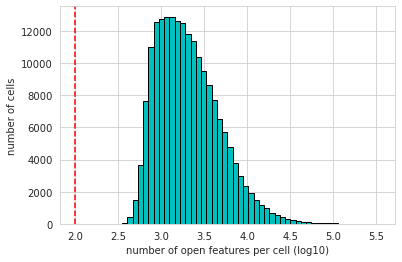

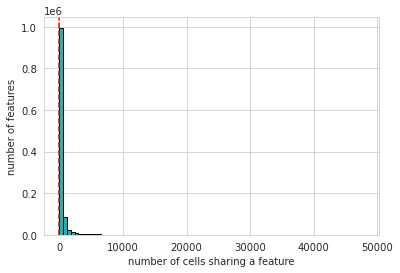

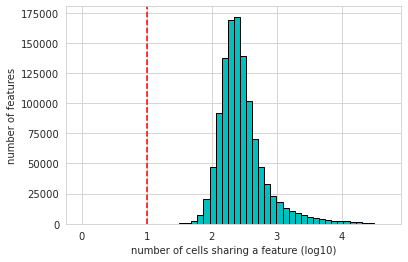

In [10]:
# show open features per cell
min_features = 100

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features)

# show numbers of cells sharing features
min_cells = 10

epi.pp.coverage_features(adata, binary=True, log=False, bins=50,
               threshold=min_cells)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50,
               threshold=min_cells)

### Visualize feature distribution (Violin)

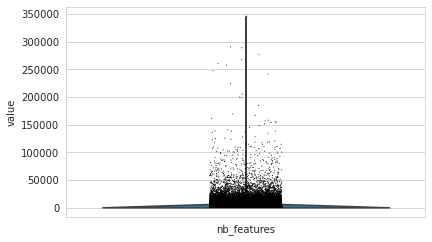

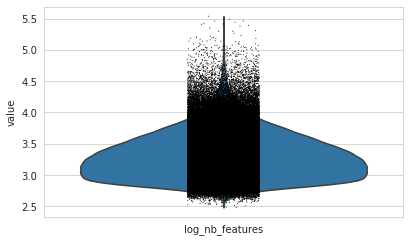

In [11]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

### Filter cells and features

In [12]:
epi.pp.filter_cells(adata, min_features=100)
epi.pp.filter_cells(adata, max_features=10000)

In [13]:
epi.pp.filter_features(adata, min_cells=10)
epi.pp.filter_features(adata, max_cells=150)

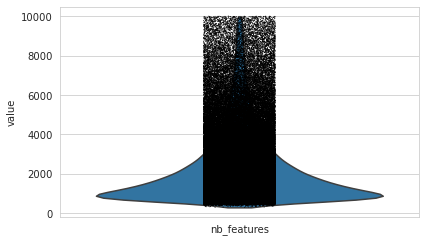

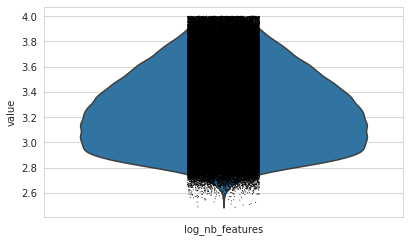

In [14]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [15]:
adata

AnnData object with n_obs × n_vars = 185734 × 503401
    obs: 'batch', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'
    layers: 'binary'

## Cluster data

### Normalize remaining data

In [16]:
sc.pp.normalize_total(adata)
adata.layers['normalised'] = adata.X.copy()
epi.pp.log1p(adata)

### Calculate neighbors and clusters

In [17]:
sc.pp.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

### Cluster with louvain algorithm and show UMAP
Testing showed good results with:
- umap(min_dist = 0.1, spread = 2.0)
- louvian(resolution = 0.7, use_weights=False)

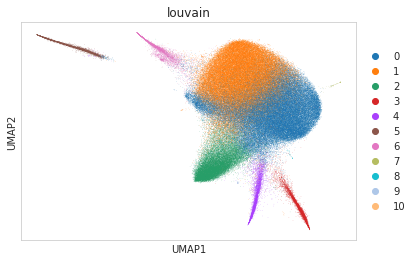

In [18]:
sc.tl.umap(adata, min_dist=0.1, spread=2.0)
sc.tl.louvain(adata, resolution=0.7, use_weights=False)

umap_plot = sc.pl.umap(adata, color=['louvain'], wspace=0.4, return_fig=True)
plt.savefig(f'{OUTPUT_PATH}/{TISSUE}/preprocessing/Cluster_{TISSUE}.png')
plt.show()

### Write files for subsequent processing

In [19]:
output_wp3 = f"{OUTPUT_PATH}/{TISSUE}/wp3/clusters_{TISSUE}.tsv"

with open(output_wp3, "w") as tsv_file:
    tsv_file.write("barcode\tcluster\n")
    for barcode in range(len(adata.obs.index)):
        line = f"{adata.obs.index[barcode]}\t{adata.obs['louvain'][barcode]}\n"
        tsv_file.write(line)

In [20]:
output_wp4 = f'{OUTPUT_PATH}/{TISSUE}/wp4/{TISSUE}'
adata.var.to_csv(f'{output_wp4}_var.csv', sep='\t')
scio.mmwrite(f'{output_wp4}_X.mtx', adata.X)

with open(f'{output_wp4}_obs.csv', "w") as obs_file:
    obs_file.write("barcode\tcluster\n")
    for barcode in range(len(adata.obs.index)):
        line = f"{adata.obs.index[barcode]}\t{adata.obs['louvain'][barcode]}\n"
        obs_file.write(line)

## Gene Annotation

### Find genes

In [21]:
epi.tl.find_genes(adata,
           gtf_file=GTF_PATH,
           key_added='gene_annotation',
           upstream=10000,
           feature_type='gene',
           annotation='havana',
           raw=False)

adata.var['gene_annotation']

chr1_79215_79615                                            intergenic
chr1_102755_103155                                          intergenic
chr1_276109_276509                                          intergenic
chr1_631178_631578        MTCO2P12;MTCO3P12;MTCO1P12;MTATP8P1;MTATP6P1
chr1_794897_795297                                           LINC01409
                                              ...                     
chrY_20699407_20699807                                      intergenic
chrY_20828004_20828404                                      intergenic
chrY_20828469_20828869                                      intergenic
chrY_20997429_20997829                                      intergenic
chrY_21021910_21022310                                      unassigned
Name: gene_annotation, Length: 503401, dtype: object

### Filter unassigned / intergenic features

In [22]:
assigned_features = adata.var[adata.var['gene_annotation'] != "intergenic"]
assigned_features = assigned_features[assigned_features['gene_annotation'] != "unassigned"]
assigned_adata = adata[:, assigned_features.index]

assigned_adata

View of AnnData object with n_obs × n_vars = 185734 × 72477
    obs: 'batch', 'nb_features', 'log_nb_features', 'louvain'
    var: 'n_cells', 'commonness', 'gene_annotation'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

### Replace peaks with gene names
Make new feature names unique and write them into raw

In [23]:
names = []

for n in assigned_adata.var['gene_annotation'].values:
    names.append(n)
    
assigned_adata.var_names = pd.Index(names)

In [24]:
assigned_adata.var_names_make_unique(join="_")
assigned_adata.raw = assigned_adata

### Rank genes

... storing 'gene_annotation' as categorical


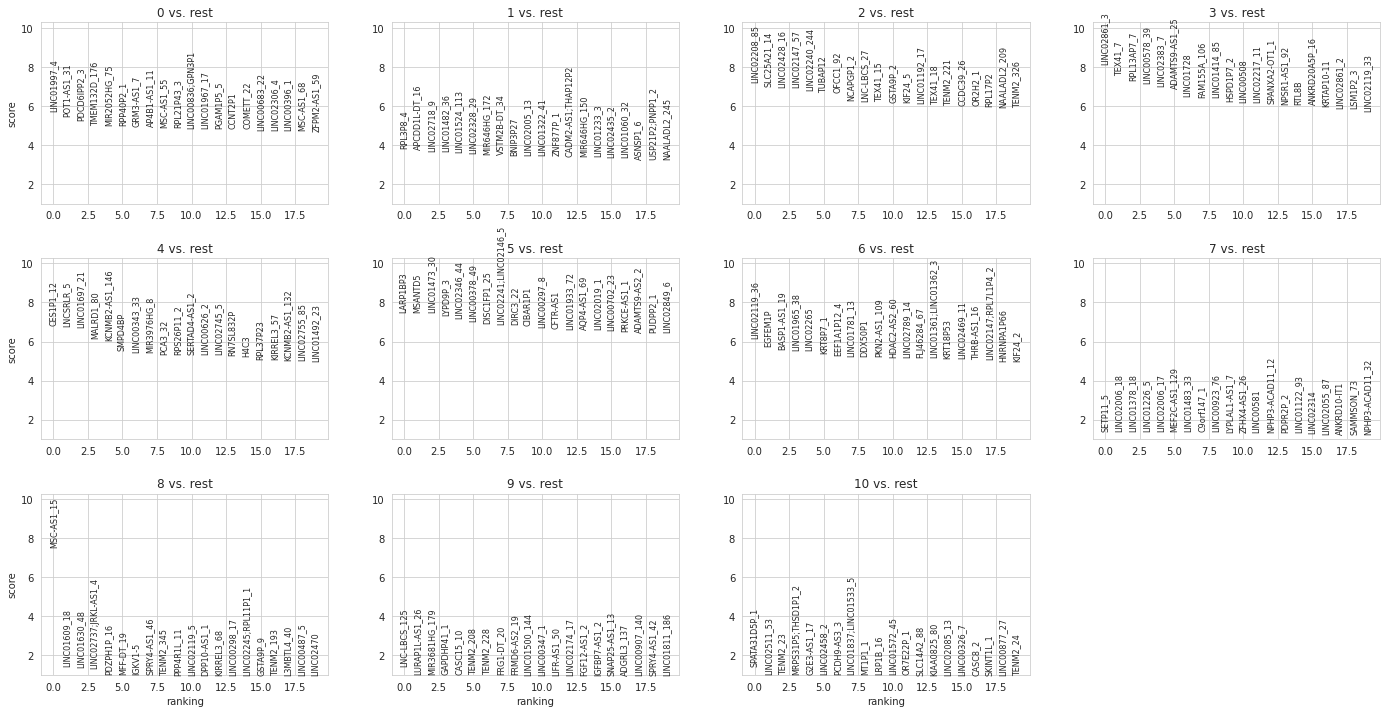

In [25]:
sc.tl.rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.tl.filter_rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(assigned_adata)

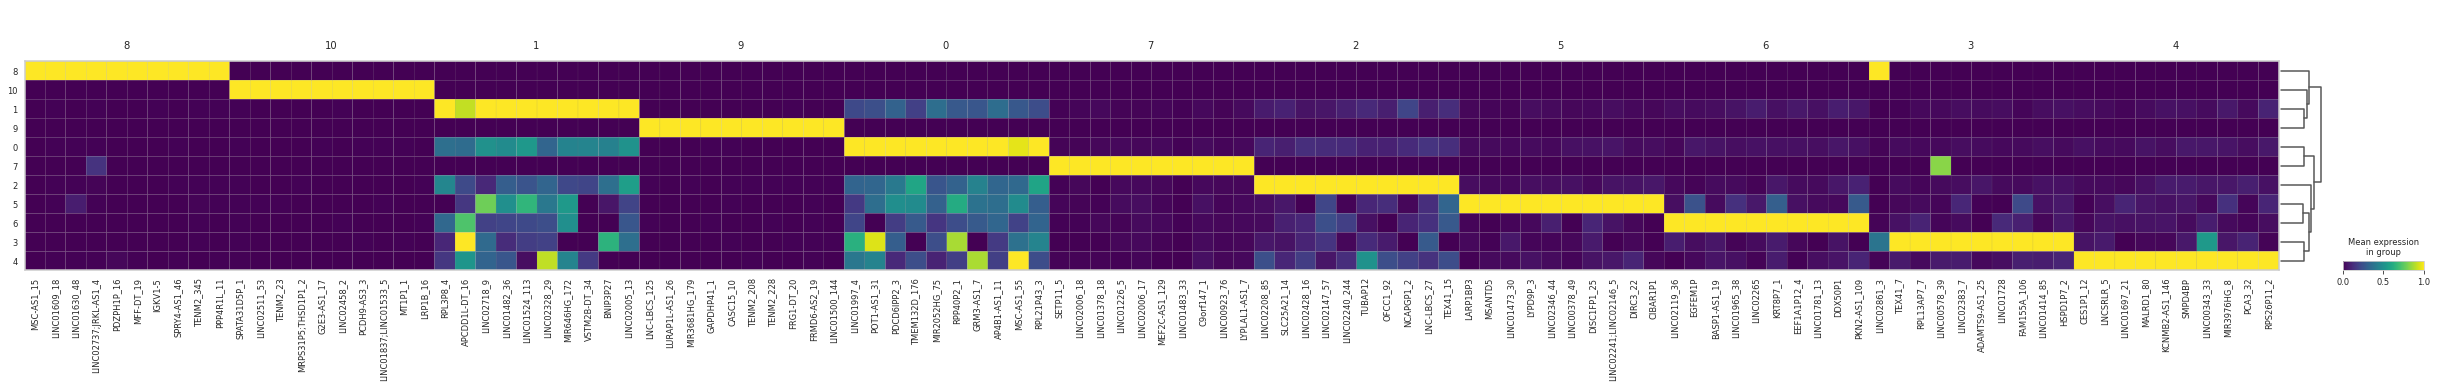

In [26]:
sc.pl.rank_genes_groups_matrixplot(assigned_adata, standard_scale='var', n_genes=10)

## Preparing for celltyp annotation

### Remove marker gene count
Before: gene_count

After: gene

In [27]:
result = assigned_adata.uns['rank_genes_groups']
for i, name_list in enumerate(result['names']):
    for j, name_string in enumerate(name_list):
        result['names'][i][j] = name_string.split('_')[0]

pd.DataFrame(result['names'])

,0,1,2,3,4,5,6,7,8,9,10
0,LINC01997,RPL3P8,LINC02208,LINC02861,CES1P1,LARP1BP3,LINC02119,SETP11,MSC-AS1,LNC-LBCS,SPATA31D5P
1,POT1-AS1,APCDD1L-DT,SLC25A21,TEX41,LNCSRLR,MSANTD5,EGFEM1P,LINC02006,LINC01609,LURAP1L-AS1,LINC02511
2,PDCD6IPP2,LINC02718,LINC02428,RPL13AP7,LINC01697,LINC01473,BASP1-AS1,LINC01378,LINC01630,MIR3681HG,TENM2
3,TMEM132D,LINC01482,LINC02147,LINC00578,MALRD1,LYPD9P,LINC01965,LINC01226,LINC02737;JRKL-AS1,GAPDHP41,MRPS31P5;THSD1P1
4,MIR2052HG,LINC01524,LINC02240,LINC02383,KCNMB2-AS1,LINC02346,LINC02265,LINC02006,PDZPH1P,CASC15,G2E3-AS1
...,...,...,...,...,...,...,...,...,...,...,...
72472,LNC-LBCS,LINC01926,PLS3-AS1,LINC01482,STX18-AS1,LINC01242,LUCAT1,TEX41,TEX41,TEX41,TEX41
72473,LINC00578,LINC02082,FLJ46284,RPSAP7,LINC01088,HMGB1P46,PSMD7-DT,LINC02893,LINC02893,LINC02893,LINC02893
72474,KHDRBS2-OT1,TEX41,LINC02805,RSF1-IT2,LINC01630,RPSAP7,PTTG1IP2,L3MBTL4,L3MBTL4,L3MBTL4,L3MBTL4
72475,RPL13AP7,KIAA0825,ARHGEF26-AS1,LRP1B,TENM3,RBMS3-AS2,TEX41,LINC01376,LINC01376,LINC01376,LINC01376


### Find first 100 unique marker genes per cluster

In [28]:
indices = {}
cutoff = 100

groups = result['names'].dtype.names
for group in groups:
    uniques = []
    indices[group] = []
    for i, value in enumerate(result['names'][group]):
        if value in uniques:
            continue
        uniques.append(value)
        indices[group].append(i)
        if len(uniques) == cutoff:
            break

## Cell Type Annotation with SCSA

### Creating csv for SCSA

In [29]:
output_sc_csv = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}.csv"

groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group][indices[group]] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv(output_sc_csv)

### Create bash command

In [30]:
python3 = "/home/stud2/.conda/envs/datanew/bin/python3.9"
scsa_loc = f"/mnt/workspace_stud/stud2/SCSA/SCSA.py"
wholeDB_loc = f"/mnt/workspace_stud/stud2/SCSA/whole.db"
input_csv = output_sc_csv
results_file = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}_result"
output_file = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}_scsa.txt"

scsa_cmd = f"{python3} {scsa_loc} -d {wholeDB_loc} -i {input_csv} -s scanpy -E -f 1.5 -p 0.01 -o {results_file} -m txt"
scsa_cmd += f" > {output_file}; tail -{len(groups) + 1} {output_file}"
print(scsa_cmd)

/home/stud2/.conda/envs/datanew/bin/python3.9 /mnt/workspace_stud/stud2/SCSA/SCSA.py -d /mnt/workspace_stud/stud2/SCSA/whole.db -i /mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete.csv -s scanpy -E -f 1.5 -p 0.01 -o /mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete_result -m txt > /mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete_scsa.txt; tail -12 /mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete_scsa.txt


In [31]:
!$scsa_cmd

#Cluster Type Celltype Score Times
['0', 'Good', 'B cell', 1.4994969124259805, 3.2366409231871685]
['1', 'N', '-', '-', '-']
['10', 'N', '-', '-', '-']
['2', 'Good', 'Ciliated epithelial cell', 1.904543511511856, 36.01041458689727]
['3', 'Good', 'Oligodendrocyte', 1.2010172032482722, '-']
['4', 'Good', 'Plasmacytoid dendritic cell', 1.730622013050995, 8.80927445403958]
['5', 'Good', 'Ciliated epithelial cell', 1.7887706273939696, 4.088469353262795]
['6', 'Good', 'Oligodendrocyte', 1.1547005383796822, 2.0000000000022378]
['7', 'N', '-', '-', '-']
['8', 'N', '-', '-', '-']
['9', 'N', '-', '-', '-']


### View results

In [32]:
pd.read_csv(results_file, sep='\t')

,Cell Type,Z-score,Cluster
0,B cell,1.499497,0
1,Monocyte,-0.463288,0
2,Lake et al.Science.Ex6,-0.516009,0
3,Sertoli cell,-0.520200,0
4,Ciliated epithelial cell,1.904544,2
5,FGFR1HighNME5- epithelial cell,0.052889,2
6,Leydig precursor cell,-0.168410,2
7,Multilymphoid progenitor cell,-0.168410,2
8,AXL+SIGLEC6+ dendritic cell,-0.810306,2
9,Natural killer T (NKT) cell,-0.810306,2


In [33]:
s = open(output_file).read().splitlines()
s

['Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 "Namespace(input='/mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete.csv', output='/mnt/workspace_stud/stud2/output/liver_complete/preprocessing/liver_complete_result', db='/mnt/workspace_stud/stud2/SCSA/whole.db', source='scanpy', cluster='all', MarkerDB=None, foldchange=1.5, pvalue=0.01, weight=100.0, species='Human', tissue='All', outfmt='txt', celltype='normal', target='cellmarker', Gensymbol=True, norefdb=False, noprint=False, list_tissue=False)",
 'Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 'load markers: 45409',
 '############################## Cluster 0 ##############################',
 '',
 'Cell Num: 4',
 'Gene Num: 3',
 'Not Zero: 5',
 'Cluster 0 Gene number: 50',
 '------------------------------------------------------------',
 'Type                Cell Type           Score     Times',
 '------------------------------------------------------------',
 'Good       

### Assign celltypes to clusters

In [34]:
cluster_celltypes = {}

with open(output_file, 'r') as cluster_result:
    skip = True
    for line in cluster_result.read().splitlines():
        if line.startswith('#Cluster'):
            skip = False
            continue
        if skip:
            continue
            
        line = line.replace("[", "").replace("]", "").replace("'", "").split(",")
        cluster = line[0]
        celltype = line[2].split("|")[0].lstrip().replace(" ", "_")
        
        cluster_celltypes[cluster] = celltype

### Write out bed files

In [35]:
for cluster in adata.obs['louvain'].unique():
    celltype = cluster_celltypes.get(cluster, [])
    if not celltype:
        continue
    
    cluster_adata = adata[adata.obs['louvain'] == cluster]
    epi.pp.filter_features(cluster_adata, min_cells=1)
    cluster_path = f'{OUTPUT_PATH}/{TISSUE}/wp6/{TISSUE}.{cluster}.{cluster_celltypes[cluster]}.bed'
    
    with open(cluster_path, 'w') as cl_output:
        for peak in cluster_adata.var.index:
            tmp = peak.replace('_', '\t')
            try:
                chromosome = int(tmp.split('\t')[0].replace('chr', ''))
            except:
                continue
            cl_output.write(f"{tmp}\n")

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
